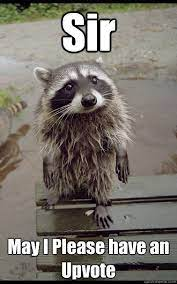

# PLEASE CHECKOUT MY NEW DATASET
- https://www.kaggle.com/keagle/mountains-dataset-with-coordinates-and-countries
- https://www.kaggle.com/keagle/list-of-indian-festivals-for-2022

Based on previous works
# Petfinder.my - Pawpularity Contest: Simple EDA and fastai starter

## A look at the data
Let's start out by setting up our environment by importing the required modules and setting a random seed:

In [1]:
!pip3 install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [2]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model

In [3]:
from fastai.vision.all import *

In [4]:
set_seed(999, reproducible=True)
BATCH_SIZE = 32

Let's check what data is available to us:

In [5]:
dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()

(#5) [Path('../input/petfinder-pawpularity-score/test.csv'),Path('../input/petfinder-pawpularity-score/sample_submission.csv'),Path('../input/petfinder-pawpularity-score/train.csv'),Path('../input/petfinder-pawpularity-score/test'),Path('../input/petfinder-pawpularity-score/train')]

We can see that we have our train csv file with the train image names, metadata and labels, the test csv file with test image names and metadata, the sample submission csv with the test image names, and the train and test image folders.

Let's check the train csv file:

In [6]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


The metadata provided includes information about key visual quality and composition parameters of the photos. The Pawpularity Score is derived from the profile's page view statistics. This is the target we are aiming to predict.

Let's do some quick processing of the image filenames to make it easier to access:

In [7]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,../input/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,../input/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,../input/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg


Okay, let's check how many images are available in the training dataset:

In [8]:
len_df = len(train_df)
print(f"There are {len_df} images")

There are 9912 images


Let's check the distribution of the Pawpularity Score:

The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.591990105774553


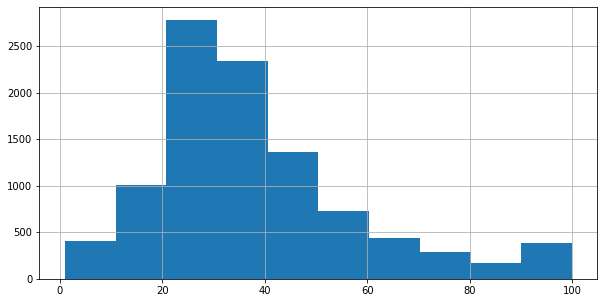

In [9]:
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

In [10]:
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

There are 100 unique values of Pawpularity score


Note that the Pawpularity score is an integer, so in addition to being a regression problem, it could also be treated as a 100-class classification problem. Alternatively, it can be treated as a binary classification problem if the Pawpularity Score is normalized between 0 and 1:

In [11]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

0       0.50
1       0.25
2       0.27
3       0.19
4       0.27
        ... 
9907    0.26
9908    0.65
9909    0.38
9910    0.44
9911    0.62
Name: norm_score, Length: 9912, dtype: float64

Let's check an example image to see what it looks like:

In [12]:
im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height)

960 960


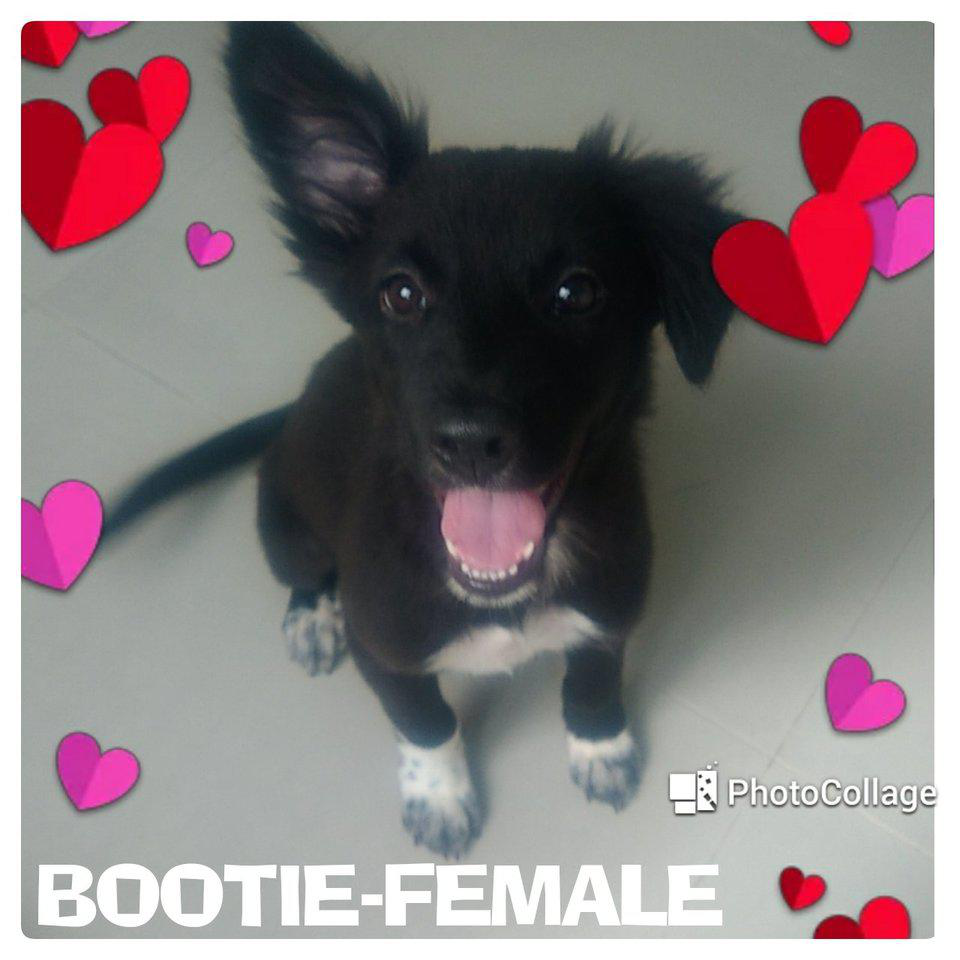

In [13]:
im

## Data loading
After my quick 'n dirty EDA, let's load the data into fastai as DataLoaders objects. We're using the normalized score as the label. I use some fairly basic augmentations here.

In [14]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'


In [15]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [16]:
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
# num_bins

<AxesSubplot:>

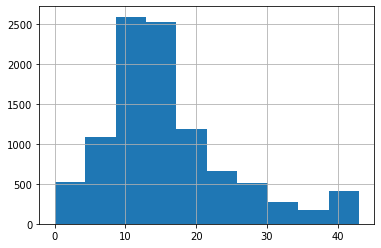

In [17]:
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

<AxesSubplot:>

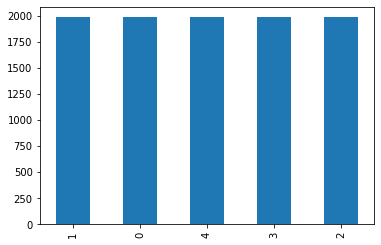

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 5
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [19]:
train_df[train_df['fold']==0].head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score,bins,fold
16,0,0,1,1,0,0,0,0,0,0,0,0,50,../input/petfinder-pawpularity-score/train/0a12576d99ec278f415c51f47279e89a.jpg,0.50,21,0
17,0,1,1,1,0,0,0,0,0,0,0,0,36,../input/petfinder-pawpularity-score/train/f3691bb7204b3e84ff7a879cef2a0da8.jpg,0.36,15,0
21,0,1,1,1,0,0,0,0,0,0,0,0,11,../input/petfinder-pawpularity-score/train/b4ebd690c2b69803b1cd38786c8b7bfc.jpg,0.11,4,0
23,0,1,1,1,0,0,0,0,0,0,0,0,55,../input/petfinder-pawpularity-score/train/ab5602ec4002932525238ec80e828d0e.jpg,0.55,23,0
24,0,1,1,1,0,0,0,0,1,1,0,0,31,../input/petfinder-pawpularity-score/train/b62c7148e72cc49d0ee89c4a523d56be.jpg,0.31,13,0


In [20]:
train_df[train_df['fold']==0]['bins'].value_counts()

11    187
15    140
12    125
13    120
10    108
9      98
14     97
7      84
20     75
17     74
8      72
16     72
18     68
43     61
19     51
23     50
21     42
27     35
0      34
6      33
22     32
4      31
5      29
25     25
24     25
31     23
26     21
28     19
3      15
1      14
30     13
29     13
32     12
33     11
35     11
2      11
34      9
40      8
38      8
36      8
37      6
41      5
42      4
39      4
Name: bins, dtype: int64

In [21]:
train_df[train_df['fold']==1]['bins'].value_counts()

11    187
15    140
12    125
13    120
10    108
9      98
14     97
7      84
20     75
17     74
8      72
16     72
18     69
43     60
19     51
23     50
21     42
27     35
0      34
22     32
6      32
4      31
5      29
24     25
25     25
31     22
26     21
28     19
3      15
1      14
29     14
30     13
35     12
33     11
2      11
32     11
34     10
38      8
36      8
40      8
37      6
41      5
39      4
42      4
Name: bins, dtype: int64

In [22]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

def petfinder_rmse_prob(input,target):
    return 100*torch.sqrt(F.mse_loss(input.flatten(), target))

In [23]:
def get_data(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    return dls


In [24]:
#Valid Kfolder size
the_data = get_data(0)
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [25]:
model_path = 'swin_large_patch4_window7_224'
def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = create_model(model_path, pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16()
    
    return learn

In [26]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [27]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

In [28]:
#get_learner(fold_num=0).lr_find(end_lr=3e-2)

In [29]:
import gc

In [30]:
all_preds = []

losses = []

train_df['pred'] = 0

for i in range(N_FOLDS):

    print(f'= {i} results')
    
    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(),
                        EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    val_preds, val_targets = learn.get_preds(1)
    loss = petfinder_rmse_prob(val_preds, val_targets)
    losses.append(loss)
    
    train_df.loc[train_df['fold'] == i, 'pred'] = val_preds[:, 0].cpu().numpy()
    
    learn.save(f'{model_path}_{i}.bin')
    #learn.recorder.plot_loss()

    #torch.cuda.empty_cache()

    
    gc.collect()
    print('RMSE', np.mean(losses))

= 0 results


/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.652112,0.647718,18.451406,01:26
1,0.640546,0.643081,17.829121,01:28
2,0.638437,0.639772,17.366879,01:28
3,0.628495,0.640356,17.390921,01:29
4,0.630993,0.639973,17.345724,01:29


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6477178335189819.
Better model found at epoch 1 with valid_loss value: 0.6430808901786804.
Better model found at epoch 2 with valid_loss value: 0.6397724747657776.


RMSE 17.559647
= 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.653427,0.645677,18.084953,01:29
1,0.642552,0.642218,17.616863,01:29
2,0.636274,0.640649,17.378700,01:29
3,0.630260,0.641113,17.410753,01:29
4,0.628005,0.640443,17.354679,01:30


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6456767916679382.
Better model found at epoch 1 with valid_loss value: 0.6422179937362671.
Better model found at epoch 2 with valid_loss value: 0.6406492590904236.
Better model found at epoch 4 with valid_loss value: 0.6404433250427246.


RMSE 17.578041
= 2 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.654382,0.645491,18.068876,01:29
1,0.640406,0.644529,17.866636,01:30
2,0.637992,0.640632,17.409483,01:29
3,0.630043,0.642140,17.588373,01:30
4,0.627437,0.641992,17.563669,01:30


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6454906463623047.
Better model found at epoch 1 with valid_loss value: 0.6445291638374329.
Better model found at epoch 2 with valid_loss value: 0.6406322121620178.
No improvement since epoch 2: early stopping


RMSE 17.586473
= 3 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.650410,0.646960,18.167402,01:30
1,0.645381,0.642681,17.624771,01:30
2,0.634007,0.642891,17.640182,01:30
3,0.629871,0.643517,17.675461,01:30


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6469597220420837.
Better model found at epoch 1 with valid_loss value: 0.6426810622215271.
No improvement since epoch 1: early stopping


RMSE 17.672289
= 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.652914,0.643953,17.858309,01:30
1,0.643991,0.638771,17.138100,01:29
2,0.638048,0.637635,16.999538,01:30
3,0.631901,0.638102,17.019281,01:30
4,0.627736,0.638289,17.022186,01:30


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6439534425735474.
Better model found at epoch 1 with valid_loss value: 0.6387714147567749.
Better model found at epoch 2 with valid_loss value: 0.6376346349716187.
No improvement since epoch 2: early stopping


RMSE 17.590466


In [31]:
train_df.to_csv('train_cv_score.csv', index=False)

In [32]:
raise Exception('stop')

Exception: stop

In [ ]:
val_preds[:, 0].cpu().numpy()

In [ ]:
np.mean(np.stack(all_preds*100))

In [ ]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [ ]:
pd.read_csv('submission.csv').head()

In [ ]:
#path = './models'
#learn1 = load_learner('model_fold_2.pkl')

# Model training

Let's train a Swin Transformer model as a baseline. We will use the wonderful timm package by Ross Wightman to define the model. Since this competition doesn't allow internet access, I have added the pretrained weights from timm as a dataset, and the below code cell will allow timm to find the file:

Let's now define the model.

Let's also define the metric we will use. Note that we multiply by 100 to get a relevant RMSE for Pawpularity Score prediction, not prediction of the normalized score.

In fastai, the trainer class is the `Learner`, which takes in the data, model, optimizer, loss function, etc. and allows you to train models, make predictions, etc. Let's define the `Learner` for this task, and also use mixed precision. Note that we use `BCEWithLogitsLoss` to treat this as a classification problem.

We are now provided with a Learner object. In order to train a model, we need to find the most optimal learning rate, which can be done with fastai's learning rate finder:

Let's now fine-tune the model with the desired learning rate of 2e-5. We'll save the best model and use the early stopping callback.

We plotted the loss, put the model back to fp32, and now we can export the model if we want to use later (i.e. for an inference kernel):

## Inference

It's very simple to perform inference with fastai. We preprocess the test CSV in the same way as the train CSV, and the `dls.test_dl` function allows you to create test dataloader using the same pipeline we defined earlier.

In [ ]:
# test_df = pd.read_csv(dataset_path/'test.csv')
# test_df.head()

In [ ]:
# test_df['Pawpularity'] = [1]*len(test_df)
# test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
# test_df = test_df.drop(columns=['Id'])
# train_df['norm_score'] = train_df['Pawpularity']/100

In [ ]:
# dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
#                                seed=999, #seed
#                                fn_col='path', #filename/path is in the second column of the DataFrame
#                                label_col='norm_score', #label is in the first column of the DataFrame
#                                y_block=RegressionBlock, #The type of target
#                                bs=32, #pass in batch size
#                                num_workers=8,
#                                item_tfms=Resize(224), #pass in item_tfms
#                                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
# test_dl = dls.test_dl(test_df)

In [ ]:
# test_dl.show_batch()

We can easily confirm that the test_dl is correct (the example test images provided are just noise so this is expected):

Now let's pass the dataloader to the model and get predictions. Here I am using 5x test-time augmentation which further improves model performance.

In [ ]:
#preds, _ = learn1.tta(dl=test_dl, n=5, beta=0)

Let's make a submission with these predictions!

In [ ]:
# sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
# sample_df['Pawpularity'] = preds.float().numpy()*100
# sample_df.to_csv('submission.csv',index=False)

In [ ]:
#pd.read_csv('submission.csv').head()

Now, **WE ARE DONE!**

If you enjoyed this notebook, please give it an upvote. 

Stay tuned for improvements to this notebook, potentially including a version that uses the metadata as well.

If you have any questions or suggestions, please leave a comment!